In [3]:
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 7.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 9.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 9.5 MB/s eta 0:00:00


In [85]:
import pandas as pd #to process the data 
import geopandas as gpd #to give the spatial extension to the data
import matplotlib.pyplot as plt #plot graphs
import matplotlib.colors as colors
import numpy as np #perform numerical data

import earthpy.spatial as es
import rasterio as rio
import io,requests

from shapely.geometry import Polygon
from shapely.geometry import Point


#### Area of study

In [13]:
aoi = gpd.read_file('/app/data/forest_inventory.geojson') 

In [4]:
aoi.head()

,fid,DN,layer,path,age,geometry
0,1,8,Bamboo,C:\Users\Lorenzo\Desktop\Forest Inventory Vect...,81-90,"POLYGON ((535215.565 4268625.847, 535215.634 4..."
1,2,6,Bamboo,C:\Users\Lorenzo\Desktop\Forest Inventory Vect...,51-60,"POLYGON ((535240.401 4268625.955, 535240.470 4..."
2,3,7,Bamboo,C:\Users\Lorenzo\Desktop\Forest Inventory Vect...,1-10,"POLYGON ((535215.634 4268610.027, 535215.703 4..."
3,4,4,Bamboo,C:\Users\Lorenzo\Desktop\Forest Inventory Vect...,11-20,"POLYGON ((535252.957 4268594.370, 535253.026 4..."
4,5,8,Bamboo,C:\Users\Lorenzo\Desktop\Forest Inventory Vect...,81-90,"POLYGON ((535265.375 4268594.424, 535265.444 4..."


In [5]:
aoi = aoi.drop('path',axis=1)

In [6]:
aoi.layer.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Cedar                 53.7%
Broad Leaved Trees    28.6%
Red Pine               6.2%
Cypres                 6.1%
Quercus-Larcus         3.6%
Bamboo                 1.8%
Name: layer, dtype: object

In [7]:
value_counts = aoi.groupby('layer')['age'].value_counts()
value_counts

layer               age   
Bamboo              11-20       44
                    1-10        29
                    51-60       25
                    81-90       24
                    61-80       16
                    21-30       10
                    >101         7
                    31-40        5
                    41-50        3
                    91-100       1
Broad Leaved Trees  51-60      838
                    61-80      816
                    81-90      567
                    41-50      127
                    >101        67
                    31-40       60
                    21-30       37
                    11-20       28
                    91-100      14
                    1-10        10
Cedar               61-80     1529
                    51-60     1123
                    81-90      809
                    41-50      752
                    >101       259
                    31-40      172
                    91-100     105
                    21-30   

<Axes: >

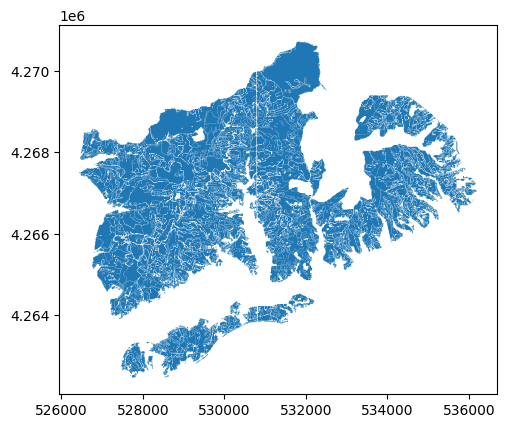

In [8]:
aoi.plot()

## Data collection

- Biomes data --> QGIS
- NDVI
- DMT


In [4]:
# load the Biomes dataset
biomes = gpd.read_file('/app/data/biome_japan.geojson',driver='GeoJSON')

In [7]:
# display all column names
pd.options.display.max_columns = None
biomes.head()

,ECO_NAME,BIOME_NUM,BIOME_NAME,ECO_BIOME_,ECO_ID,SHAPE_LENG,SHAPE_AREA,geometry
0,Hokkaido deciduous forests,4.0,Temperate Broadleaf & Mixed Forests,PA04,666,43.452516,4.297060,"MULTIPOLYGON (((146.96770 43.85054, 146.97890 ..."
1,Hokkaido montane conifer forests,5.0,Temperate Conifer Forests,PA05,698,24.742945,5.112174,"MULTIPOLYGON (((140.84781 42.53669, 140.82338 ..."
2,Honshu alpine conifer forests,5.0,Temperate Conifer Forests,PA05,699,25.768777,1.184435,"MULTIPOLYGON (((138.76599 35.28610, 138.73924 ..."
3,Nihonkai evergreen forests,4.0,Temperate Broadleaf & Mixed Forests,PA04,670,34.275361,2.172062,"MULTIPOLYGON (((133.29498 36.31850, 133.29855 ..."
4,Nihonkai montane deciduous forests,4.0,Temperate Broadleaf & Mixed Forests,PA04,671,66.626091,8.506632,"MULTIPOLYGON (((131.78441 34.31613, 131.76663 ..."


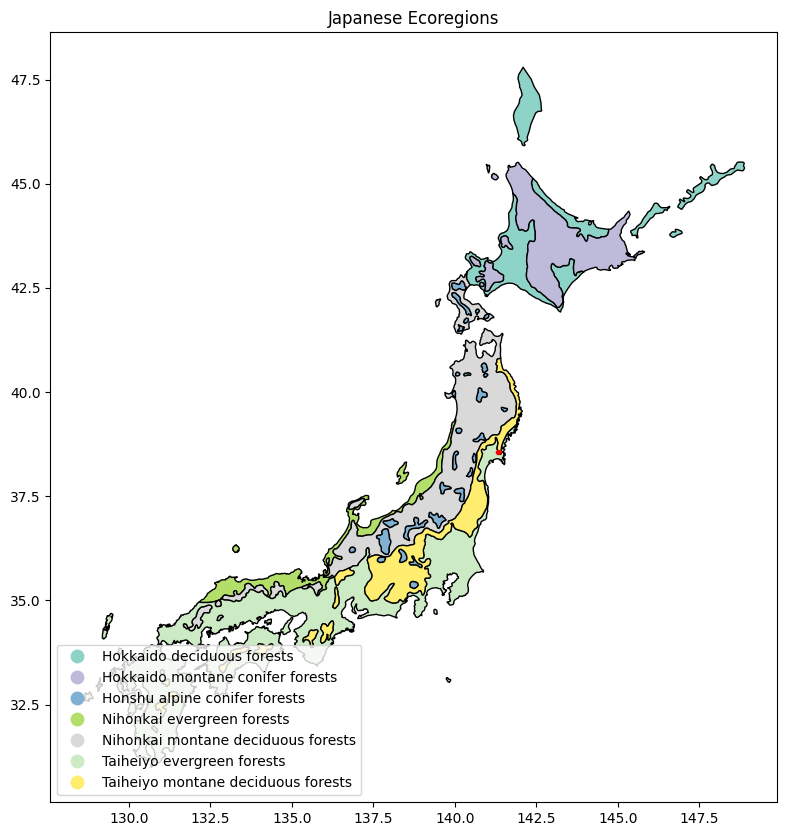

In [47]:
cmap='Set3'
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('Japanese Ecoregions')
biomes.plot(ax=ax,column='ECO_NAME',cmap=cmap,edgecolor='black',legend=True,legend_kwds= {'ncol': 1, 'loc': 'lower left'})
aoi_4326.boundary.plot(ax=ax, color="red")
plt.show()

In [18]:
aoi_4326= aoi.to_crs(4326)

In [39]:
xmin, ymin, xmax, ymax = aoi_4326.total_bounds

# Create a rectangle using the boundaries
rectangle = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])

# Create a GeoDataFrame with the rectangle
rectangle_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs=aoi_4326.crs)

<Axes: >

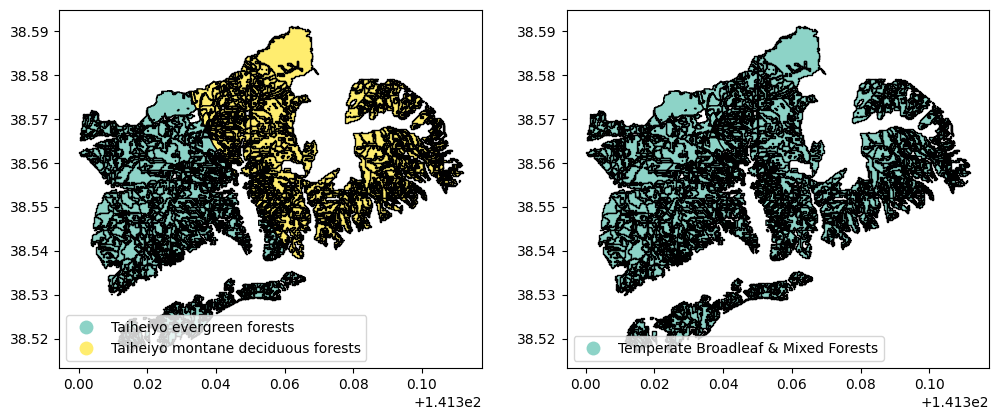

In [53]:
intersection = gpd.overlay(aoi_4326, biomes, how='intersection')

# Plot the resulting GeoDataFrame
fig, ax = plt.subplots(1,2,figsize=(12, 8))
intersection.plot(ax=ax[0], column='ECO_NAME',cmap=cmap,edgecolor='black',legend=True,legend_kwds= {'ncol': 1, 'loc': 'lower left'})
intersection.plot(ax=ax[1], column='BIOME_NAME',cmap=cmap,edgecolor='black',legend=True,legend_kwds= {'ncol': 1, 'loc': 'lower left'})

In [78]:
def subplot_species(gdf):
    """
    Creates subplots of a GeoPandas dataframe based on a column name.
    Each subplot shows the features that have the same value in the specified column.
    """
    # Get unique values in the column
    unique_values = gdf.layer.unique()

    # Calculate number of subplots needed
    num_subplots = len(unique_values)

    # Calculate number of rows and columns for the subplots
    num_rows = int(num_subplots ** 0.5)
    num_cols = int(num_subplots / num_rows) + 1

    # Create the subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12), sharex=True, sharey=True)

    # Flatten the axes array
    axs = axs.flatten()

    # Loop through the unique values and plot each subset of the GeoDataFrame
    for i, value in enumerate(unique_values):
        # Subset the GeoDataFrame by the current value
        subset = gdf[gdf['layer'] == value]

        # Plot the subset on the current subplot
        subset.plot(ax=axs[i], edgecolor='black',facecolor='green')

        # Set the title of the subplot to the current value
        axs[i].set_title(str(value))

    # Remove any unused subplots
    for i in range(num_subplots, num_rows * num_cols):
        fig.delaxes(axs[i])

    # Adjust the spacing between the subplots
    #fig.tight_layout()

    # Show the subplots
    plt.show()

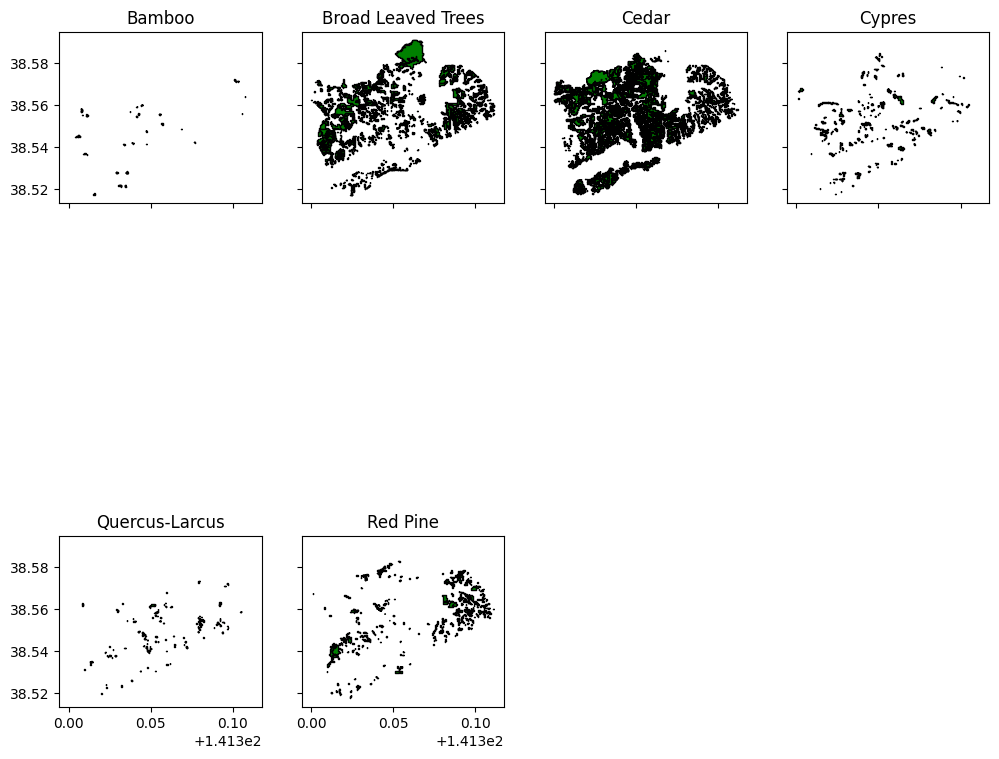

In [79]:
subplot_species(intersection)

In [107]:
fig, ay = figsize=(12, 8)

<Axes: >

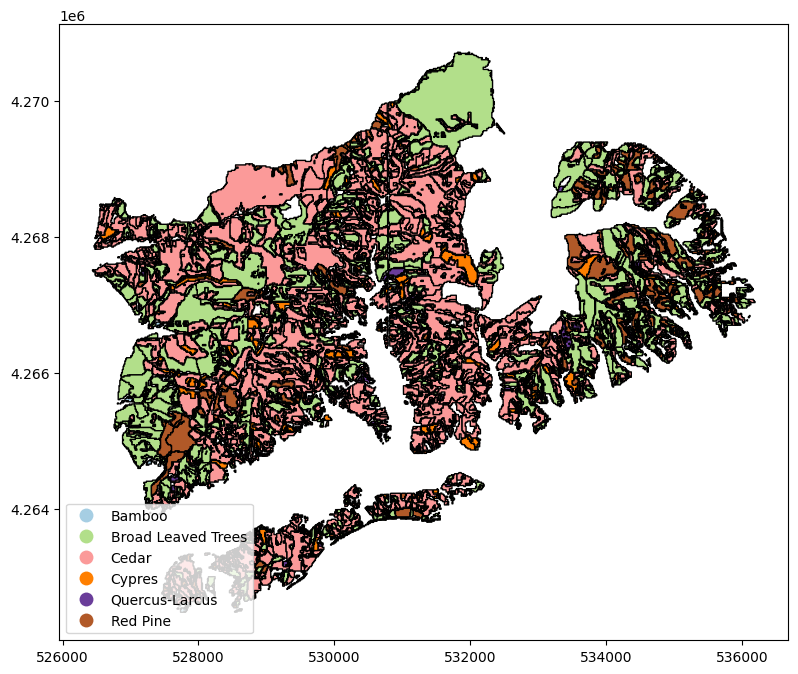

In [110]:
aoi.plot(figsize=(12,8),column='layer',cmap='Paired',edgecolor='black',legend=True,legend_kwds= {'ncol': 1, 'loc': 'lower left'})

### Climate data
Koppen Classification

In [102]:
url = "https://koppen-climate-classification.p.rapidapi.com/classification"

querystring = {"lat":"38.57","lon":"141.35"}

headers = {
    "X-RapidAPI-Key": "6989483ef7msh310d5616fedfc7bp1e5b05jsna7ba2392ee33",
    "X-RapidAPI-Host": "koppen-climate-classification.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"resource": "koppen", "location": {"latitude": "38.75", "longitude": "141.25"}, "classification": "Cfa"}


**Cfa** humid subtropical climate

- C : temperature of warmest month greater than or equal to 10 °C, and temperature of coldest month less than 18 °C but greater than –3 °C
    -  f : precipitation more evenly distributed throughout year
        - a: temperature of warmest month 22 °C or above


### NDVI

In [111]:
def load_ndvi_japan():
    # Set the URL for the NDVI dataset for Japan
    url = 'https://www.ncei.noaa.gov/data/normalized-difference-vegetation-index/access/avhrr-j1-v1/2010/avhrr_j1c_2010012_n18_n19_v1.nc'

    # Send a GET request to the URL to retrieve the file
    response = requests.get(url)

    # Read the response content and create a rasterio memory file
    with rio.MemoryFile(response.content) as memfile:
        # Open the first band of the raster file as a numpy array
        with memfile.open() as dataset:
            ndvi_array = dataset.read(1)

    return ndvi_array